# The Battle of Neighborhoods: Restaurants Social Media Popularity Mapping

Romain Bocher<br/>
December 18, 2019

## Importing Packages and Set Parameters

In [1]:
import pandas as pd
import numpy as np
import math
import json
import requests
from pandas.io.json import json_normalize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from folium.features import DivIcon
from IPython.display import HTML, display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

print('Finished!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.0.0               |             py_0         606 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

## Collecting Paris Data

In [2]:
url = 'https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true&csv_separator=%3B'
paris_data = pd.read_csv(url, delimiter=';')

In [3]:
paris_data.head(80)

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000008,8,7510204,Bonne-Nouvelle,2,750000002,2233.976030,2.814482e+05,"48.8671501183,2.35008019041","{""type"": ""Polygon"", ""coordinates"": [[[2.351518..."
1,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,7.983894e+05,"48.8419401934,2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561..."
2,750000030,30,7510802,Faubourg-du-Roule,8,750000008,3773.673073,7.965891e+05,"48.8741355756,2.30411880972","{""type"": ""Polygon"", ""coordinates"": [[[2.311968..."
3,750000052,52,7511304,Croulebarbe,13,750000013,3289.230480,6.920677e+05,"48.8337336761,2.34767304607","{""type"": ""Polygon"", ""coordinates"": [[[2.351662..."
4,750000061,61,7511601,Auteuil,16,750000016,12452.253931,6.383888e+06,"48.8506223427,2.25227690754","{""type"": ""Polygon"", ""coordinates"": [[[2.249224..."
5,750000013,13,7510401,Saint-Merri,4,750000004,2346.004687,3.130404e+05,"48.8585213723,2.35166696714","{""type"": ""Polygon"", ""coordinates"": [[[2.352623..."
6,750000016,16,7510404,Notre-Dame,4,750000004,3283.163371,3.782522e+05,"48.8528955862,2.35277501212","{""type"": ""Polygon"", ""coordinates"": [[[2.361313..."
7,750000021,21,7510601,Monnaie,6,750000006,2391.122818,2.933606e+05,"48.8543844036,2.34003537113","{""type"": ""Polygon"", ""coordinates"": [[[2.343168..."
8,750000029,29,7510801,Champs-Elysées,8,750000008,5480.652870,1.140254e+06,"48.8670744922,2.30865168468","{""type"": ""Polygon"", ""coordinates"": [[[2.306463..."
9,750000037,37,7511001,Saint-Vincent-de-Paul,10,750000010,4072.789633,9.268652e+05,"48.8807352373,2.35747081045","{""type"": ""Polygon"", ""coordinates"": [[[2.360513..."


In [4]:
paris_data.dtypes

N_SQ_QU           int64
C_QU              int64
C_QUINSEE         int64
L_QU             object
C_AR              int64
N_SQ_AR           int64
PERIMETRE       float64
SURFACE         float64
Geometry X Y     object
Geometry         object
dtype: object

In [5]:
paris_data.size

800

In [6]:
paris_data = paris_data.rename(columns={'L_QU':'Neighborhood','PERIMETRE':'Perimeter','C_AR':'PostalCode'})

In [7]:
paris_data = paris_data.drop(['N_SQ_QU','C_QU','C_QUINSEE','N_SQ_AR','SURFACE','Geometry'], axis=1)

In [8]:
paris_data.head(10)

,Neighborhood,PostalCode,Perimeter,Geometry X Y
0,Bonne-Nouvelle,2,2233.976030,"48.8671501183,2.35008019041"
1,Jardin-des-Plantes,5,4052.729521,"48.8419401934,2.35689388962"
2,Faubourg-du-Roule,8,3773.673073,"48.8741355756,2.30411880972"
3,Croulebarbe,13,3289.230480,"48.8337336761,2.34767304607"
4,Auteuil,16,12452.253931,"48.8506223427,2.25227690754"
5,Saint-Merri,4,2346.004687,"48.8585213723,2.35166696714"
6,Notre-Dame,4,3283.163371,"48.8528955862,2.35277501212"
7,Monnaie,6,2391.122818,"48.8543844036,2.34003537113"
8,Champs-Elysées,8,5480.652870,"48.8670744922,2.30865168468"
9,Saint-Vincent-de-Paul,10,4072.789633,"48.8807352373,2.35747081045"


In [9]:
paris_data[['Latitude','Longitude']] = paris_data['Geometry X Y'].str.split(',',expand=True)
paris_data.head(10)

,Neighborhood,PostalCode,Perimeter,Geometry X Y,Latitude,Longitude
0,Bonne-Nouvelle,2,2233.976030,"48.8671501183,2.35008019041",48.8671501183,2.35008019041
1,Jardin-des-Plantes,5,4052.729521,"48.8419401934,2.35689388962",48.8419401934,2.35689388962
2,Faubourg-du-Roule,8,3773.673073,"48.8741355756,2.30411880972",48.8741355756,2.30411880972
3,Croulebarbe,13,3289.230480,"48.8337336761,2.34767304607",48.8337336761,2.34767304607
4,Auteuil,16,12452.253931,"48.8506223427,2.25227690754",48.8506223427,2.25227690754
5,Saint-Merri,4,2346.004687,"48.8585213723,2.35166696714",48.8585213723,2.35166696714
6,Notre-Dame,4,3283.163371,"48.8528955862,2.35277501212",48.8528955862,2.35277501212
7,Monnaie,6,2391.122818,"48.8543844036,2.34003537113",48.8543844036,2.34003537113
8,Champs-Elysées,8,5480.652870,"48.8670744922,2.30865168468",48.8670744922,2.30865168468
9,Saint-Vincent-de-Paul,10,4072.789633,"48.8807352373,2.35747081045",48.8807352373,2.35747081045


In [10]:
paris_data = paris_data.drop(['Geometry X Y'], axis=1)
paris_data = paris_data.reset_index(drop=True)
paris_data.head(10)

,Neighborhood,PostalCode,Perimeter,Latitude,Longitude
0,Bonne-Nouvelle,2,2233.976030,48.8671501183,2.35008019041
1,Jardin-des-Plantes,5,4052.729521,48.8419401934,2.35689388962
2,Faubourg-du-Roule,8,3773.673073,48.8741355756,2.30411880972
3,Croulebarbe,13,3289.230480,48.8337336761,2.34767304607
4,Auteuil,16,12452.253931,48.8506223427,2.25227690754
5,Saint-Merri,4,2346.004687,48.8585213723,2.35166696714
6,Notre-Dame,4,3283.163371,48.8528955862,2.35277501212
7,Monnaie,6,2391.122818,48.8543844036,2.34003537113
8,Champs-Elysées,8,5480.652870,48.8670744922,2.30865168468
9,Saint-Vincent-de-Paul,10,4072.789633,48.8807352373,2.35747081045


In [11]:
paris_data.dtypes

Neighborhood     object
PostalCode        int64
Perimeter       float64
Latitude         object
Longitude        object
dtype: object

In [12]:
paris_data['Latitude'] = paris_data.Latitude.astype(float)
paris_data['Longitude'] = paris_data.Longitude.astype(float)
paris_data['PostalCode'] = paris_data.PostalCode.astype(str)
paris_data.dtypes

Neighborhood     object
PostalCode       object
Perimeter       float64
Latitude        float64
Longitude       float64
dtype: object

In [13]:
paris_data['PostalCode'] = paris_data['PostalCode'].replace( \
 ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'], \
 ['75001','75002','75003','75004','75005','75006','75007','75008','75009', \
  '75010','75011','75012','75013','75014','75015','75016','75017','75018','75019','75020'])
paris_data.head(80)

,Neighborhood,PostalCode,Perimeter,Latitude,Longitude
0,Bonne-Nouvelle,75002,2233.976030,48.867150,2.350080
1,Jardin-des-Plantes,75005,4052.729521,48.841940,2.356894
2,Faubourg-du-Roule,75008,3773.673073,48.874136,2.304119
3,Croulebarbe,75013,3289.230480,48.833734,2.347673
4,Auteuil,75016,12452.253931,48.850622,2.252277
5,Saint-Merri,75004,2346.004687,48.858521,2.351667
6,Notre-Dame,75004,3283.163371,48.852896,2.352775
7,Monnaie,75006,2391.122818,48.854384,2.340035
8,Champs-Elysées,75008,5480.652870,48.867074,2.308652
9,Saint-Vincent-de-Paul,75010,4072.789633,48.880735,2.357471


In [14]:
paris_data['Radius'] = 1.3*paris_data['Perimeter']/(2*math.pi)
paris_data.head(80)

,Neighborhood,PostalCode,Perimeter,Latitude,Longitude,Radius
0,Bonne-Nouvelle,75002,2233.976030,48.867150,2.350080,462.212826
1,Jardin-des-Plantes,75005,4052.729521,48.841940,2.356894,838.515517
2,Faubourg-du-Roule,75008,3773.673073,48.874136,2.304119,780.778340
3,Croulebarbe,75013,3289.230480,48.833734,2.347673,680.546477
4,Auteuil,75016,12452.253931,48.850622,2.252277,2576.389095
5,Saint-Merri,75004,2346.004687,48.858521,2.351667,485.391715
6,Notre-Dame,75004,3283.163371,48.852896,2.352775,679.291183
7,Monnaie,75006,2391.122818,48.854384,2.340035,494.726721
8,Champs-Elysées,75008,5480.652870,48.867074,2.308652,1133.954894
9,Saint-Vincent-de-Paul,75010,4072.789633,48.880735,2.357471,842.665983


In [15]:
paris_data = paris_data.drop(['Perimeter'], axis=1)
paris_data.head(10)

,Neighborhood,PostalCode,Latitude,Longitude,Radius
0,Bonne-Nouvelle,75002,48.867150,2.350080,462.212826
1,Jardin-des-Plantes,75005,48.841940,2.356894,838.515517
2,Faubourg-du-Roule,75008,48.874136,2.304119,780.778340
3,Croulebarbe,75013,48.833734,2.347673,680.546477
4,Auteuil,75016,48.850622,2.252277,2576.389095
5,Saint-Merri,75004,48.858521,2.351667,485.391715
6,Notre-Dame,75004,48.852896,2.352775,679.291183
7,Monnaie,75006,48.854384,2.340035,494.726721
8,Champs-Elysées,75008,48.867074,2.308652,1133.954894
9,Saint-Vincent-de-Paul,75010,48.880735,2.357471,842.665983


## Getting recommandations calling Foursquare API

In [16]:
# Fourthsquare parameters
CLIENT_ID = 'LSFPPJXBATJ1YEJ5BH35NJB2MWQ54MH1J3YILBF35HW4NDUU'
CLIENT_SECRET = 'BIEY1PNHYWK5P2U5AR2ZPEOG0QRGAH2YZB25I4JHRRYDJKC0'
VERSION = '20191217'
LIMIT = 50

In [17]:
# restaurants
categoryId_restaurants = '503288ae91d4c4b30a586d67,4bf58dd8d48988d1c8941735,4bf58dd8d48988d14e941735,4bf58dd8d48988d142941735,'\
    +'4bf58dd8d48988d169941735,52e81612bcbc57f1066b7a01,4bf58dd8d48988d1df931735,52e81612bcbc57f1066b7a02,'\
    +'52e81612bcbc57f1066b79f1,52e81612bcbc57f1066b79f4,4bf58dd8d48988d16c941735,4bf58dd8d48988d17a941735,'\
    +'4bf58dd8d48988d144941735,5293a7d53cf9994f4e043a45,52e81612bcbc57f1066b7a00,52e81612bcbc57f1066b79f2,'\
    +'52f2ae52bcbc57f1066b8b81,4bf58dd8d48988d147941735,4bf58dd8d48988d108941735,5744ccdfe4b0c0459246b4d0,'\
    +'4bf58dd8d48988d109941735,52e81612bcbc57f1066b7a05,4bf58dd8d48988d10b941735,4edd64a0c7ddd24ca188df1a,'\
    +'52e81612bcbc57f1066b7a09,4bf58dd8d48988d1cb941735,4bf58dd8d48988d10c941735,4d4ae6fc7a7b7dea34424761,'\
    +'4bf58dd8d48988d155941735,4bf58dd8d48988d10d941735,4c2cd86ed066bed06c3c5209,4bf58dd8d48988d10e941735,'\
    +'52e81612bcbc57f1066b79ff,52e81612bcbc57f1066b79fe,52e81612bcbc57f1066b79fa,4bf58dd8d48988d10f941735,'\
    +'4bf58dd8d48988d110941735,52e81612bcbc57f1066b79fd,4bf58dd8d48988d1be941735,4bf58dd8d48988d1c0941735,'\
    +'4bf58dd8d48988d1c1941735,4bf58dd8d48988d115941735,52e81612bcbc57f1066b79f9,4bf58dd8d48988d1c2941735,'\
    +'52e81612bcbc57f1066b79f8,4bf58dd8d48988d1ca941735,52e81612bcbc57f1066b7a04,4def73e84765ae376e57713a,'\
    +'56aa371be4b08b9a8d5734c7,5293a7563cf9994f4e043a44,4bf58dd8d48988d1c6941735,5744ccdde4b0c0459246b4a3,'\
    +'4bf58dd8d48988d1ce941735,56aa371be4b08b9a8d57355a,4bf58dd8d48988d1dd931735,4bf58dd8d48988d14f941735,'\
    +'4bf58dd8d48988d150941735,5413605de4b0ae91d18581a9,4bf58dd8d48988d1cc941735,4bf58dd8d48988d158941735,'\
    +'56aa371be4b08b9a8d573538,4f04af1f2fb6e1c99f3db0bb,52e928d0bcbc57f1066b7e96,4bf58dd8d48988d1d3941735'

columns_list = ['Neighborhood','Latitude','Longitude','Venue','Id']
restaurants_data = pd.DataFrame(columns=columns_list)

In [18]:
def getNearbyVenues(names, latitudes, longitudes, postalCodes, radius, categoryId):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&near={}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID,
        CLIENT_SECRET, 
        VERSION, 
        latitudes, 
        longitudes,
        postalCodes,
        radius, 
        LIMIT,
        categoryId)
    
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for v in results:
        
        venues_list.append([(
            names,
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['name'],
            v['venue']['id'],
        )])
        
    get_data = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    get_data.columns = columns_list
    
    return(get_data)

In [19]:
for index, row in paris_data.iterrows():
    
    # restaurants search
    venues_list=[]
    search_restaurants = getNearbyVenues(names=paris_data.iloc[index]['Neighborhood'],\
                    latitudes=paris_data.iloc[index]['Latitude'],\
                    longitudes=paris_data.iloc[index]['Longitude'],\
                    postalCodes=paris_data.iloc[index]['PostalCode'],\
                    radius=paris_data.iloc[index]['Radius'],\
                    categoryId=categoryId_restaurants)
    
    restaurants_data = restaurants_data.append(search_restaurants)

restaurants_data.head(20)

,Neighborhood,Latitude,Longitude,Venue,Id
0,Bonne-Nouvelle,48.865172,2.340645,Les Fines Gueules,4bbb5d897421a5939eb9c440
1,Bonne-Nouvelle,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3
2,Bonne-Nouvelle,48.865958,2.343484,Blend Argout,4eb42aad61af0dda8fcb1389
3,Bonne-Nouvelle,48.865523,2.340365,Bistrot Victoires,4b4723cbf964a520d92b26e3
4,Bonne-Nouvelle,48.868074,2.343379,Pizzeria Popolare,58bc834d7d0f6d34315f5cfe
5,Bonne-Nouvelle,48.866184,2.339501,Bistrot Vivienne,4b9aabd5f964a52099cb35e3
6,Bonne-Nouvelle,48.867130,2.339243,Daroco,5759bf21498eafba7d5e7246
7,Bonne-Nouvelle,48.863776,2.345660,Presto Fresco,4b90f784f964a520a19c33e3
8,Bonne-Nouvelle,48.865641,2.346302,Cloud Cakes,57dd0809cd10776425c22dd7
9,Bonne-Nouvelle,48.865986,2.337899,Le Grand Véfour,4adcda13f964a520e63621e3


In [20]:
restaurants_data = restaurants_data.reset_index(drop=True)


In [21]:
rest_count = len(restaurants_data)
print(rest_count)

4000


## Filtering Restaurants with Eigenvector Centrality

In [22]:
restaurants_data['Eigenvector Centrality'] = 0
restaurants_data.head(10)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality
0,Bonne-Nouvelle,48.865172,2.340645,Les Fines Gueules,4bbb5d897421a5939eb9c440,0
1,Bonne-Nouvelle,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0
2,Bonne-Nouvelle,48.865958,2.343484,Blend Argout,4eb42aad61af0dda8fcb1389,0
3,Bonne-Nouvelle,48.865523,2.340365,Bistrot Victoires,4b4723cbf964a520d92b26e3,0
4,Bonne-Nouvelle,48.868074,2.343379,Pizzeria Popolare,58bc834d7d0f6d34315f5cfe,0
5,Bonne-Nouvelle,48.866184,2.339501,Bistrot Vivienne,4b9aabd5f964a52099cb35e3,0
6,Bonne-Nouvelle,48.867130,2.339243,Daroco,5759bf21498eafba7d5e7246,0
7,Bonne-Nouvelle,48.863776,2.345660,Presto Fresco,4b90f784f964a520a19c33e3,0
8,Bonne-Nouvelle,48.865641,2.346302,Cloud Cakes,57dd0809cd10776425c22dd7,0
9,Bonne-Nouvelle,48.865986,2.337899,Le Grand Véfour,4adcda13f964a520e63621e3,0


In [23]:
def calculateDistance(pos1, pos2, r=6371009):

    locs_1 = np.deg2rad(pos1)
    locs_2 = np.deg2rad(pos2)

    lat_dif = (locs_1[:,0][:,None]/2 - locs_2[:,0]/2)
    lon_dif = (locs_1[:,1][:,None]/2 - locs_2[:,1]/2)

    np.sin(lat_dif, out=lat_dif)
    np.sin(lon_dif, out=lon_dif)

    np.power(lat_dif, 2, out=lat_dif)
    np.power(lon_dif, 2, out=lon_dif)

    lon_dif *= ( np.cos(locs_1[:,0])[:,None] * np.cos(locs_2[:,0]) )
    lon_dif += lat_dif

    np.arctan2(np.power(lon_dif,.5), np.power(1-lon_dif,.5), out = lon_dif)
    lon_dif *= (2 * r)

    return lon_dif
            

In [24]:
# generate distance array
distance_array = calculateDistance(restaurants_data[['Latitude','Longitude']].values,restaurants_data[['Latitude','Longitude']].values)
# add 1 cm to each distance in order to get the reciprocal of each element (even the diagonal with 0)
distance_array += 0.01
# get the reciprocal of each distance => adgency matrix
distance_array = np.reciprocal(distance_array)
distance_array

array([[1.00000000e+02, 2.90356597e-03, 4.43753728e-03, ...,
        2.86432789e-04, 2.01386780e-04, 2.52877720e-04],
       [2.90356597e-03, 1.00000000e+02, 4.92768304e-03, ...,
        2.60724636e-04, 1.89050181e-04, 2.33942621e-04],
       [4.43753728e-03, 4.92768304e-03, 1.00000000e+02, ...,
        2.71503584e-04, 1.92877317e-04, 2.39500543e-04],
       ...,
       [2.86432789e-04, 2.60724636e-04, 2.71503584e-04, ...,
        1.00000000e+02, 4.99880900e-04, 7.04888261e-04],
       [2.01386780e-04, 1.89050181e-04, 1.92877317e-04, ...,
        4.99880900e-04, 1.00000000e+02, 9.76487036e-04],
       [2.52877720e-04, 2.33942621e-04, 2.39500543e-04, ...,
        7.04888261e-04, 9.76487036e-04, 1.00000000e+02]])

In [25]:
rest_list = restaurants_data.index.tolist()
G = nx.from_numpy_array(distance_array)
print('finished!')

finished!


In [26]:
# calculate eigenvector centralities
centrality = nx.eigenvector_centrality_numpy(G)
print(centrality)

{0: 0.0158113883008419, 1: 0.015811388300841896, 2: 0.015811388300841896, 3: 0.015811388300841896, 4: 0.015811388300841896, 5: 0.015811388300841896, 6: 0.015811388300841896, 7: 0.015811388300841896, 8: 0.0158113883008419, 9: 0.0158113883008419, 10: 0.0158113883008419, 11: 0.0158113883008419, 12: 0.015811388300841896, 13: 0.015811388300841896, 14: 0.0158113883008419, 15: 0.015811388300841896, 16: 0.015811388300841892, 17: 0.015811388300841892, 18: 0.015811388300841896, 19: 0.0158113883008419, 20: 0.015811388300841896, 21: 0.015811388300841896, 22: 0.015811388300841896, 23: 0.0158113883008419, 24: 0.015811388300841896, 25: 0.0158113883008419, 26: 0.0158113883008419, 27: 0.015811388300841892, 28: 0.015811388300841892, 29: 0.0158113883008419, 30: 0.015811388300841892, 31: 0.0158113883008419, 32: 0.015811388300841896, 33: 0.015811388300841896, 34: 0.015811388300841896, 35: 0.015811388300841896, 36: 0.015811388300841896, 37: 0.015811388300841896, 38: 0.0158113883008419, 39: 0.015811388300841

In [27]:
restaurants_data['Eigenvector Centrality'] = restaurants_data['Eigenvector Centrality'].astype(float)
for node in centrality:
    restaurants_data.at[node,'Eigenvector Centrality'] = round(centrality[node],20)

restaurants_data.head(20)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality
0,Bonne-Nouvelle,48.865172,2.340645,Les Fines Gueules,4bbb5d897421a5939eb9c440,0.015811
1,Bonne-Nouvelle,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811
2,Bonne-Nouvelle,48.865958,2.343484,Blend Argout,4eb42aad61af0dda8fcb1389,0.015811
3,Bonne-Nouvelle,48.865523,2.340365,Bistrot Victoires,4b4723cbf964a520d92b26e3,0.015811
4,Bonne-Nouvelle,48.868074,2.343379,Pizzeria Popolare,58bc834d7d0f6d34315f5cfe,0.015811
5,Bonne-Nouvelle,48.866184,2.339501,Bistrot Vivienne,4b9aabd5f964a52099cb35e3,0.015811
6,Bonne-Nouvelle,48.867130,2.339243,Daroco,5759bf21498eafba7d5e7246,0.015811
7,Bonne-Nouvelle,48.863776,2.345660,Presto Fresco,4b90f784f964a520a19c33e3,0.015811
8,Bonne-Nouvelle,48.865641,2.346302,Cloud Cakes,57dd0809cd10776425c22dd7,0.015811
9,Bonne-Nouvelle,48.865986,2.337899,Le Grand Véfour,4adcda13f964a520e63621e3,0.015811


In [28]:
best_restaurants = restaurants_data.sort_values('Eigenvector Centrality',ascending=False).head(400)
best_restaurants.reset_index(drop=True)
best_restaurants.head(400)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality
1984,Ecole-Militaire,48.849660,2.325133,L'Épi Dupin,4adcda11f964a520e33521e3,0.015811
1286,Saint-Germain-l'Auxerrois,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811
2257,Salpêtrière,48.836067,2.358755,Royal Bombay,4cab753ed971b1f7bc302be1,0.015811
911,Place-Vendôme,48.860176,2.345348,Saudade,506dd0f3e4b082a2a931ee12,0.015811
2086,Montparnasse,48.834098,2.328979,Le Bouquet Daguerre,4ba37c10f964a520154138e3,0.015811
364,Monnaie,48.849133,2.334795,La Cuisine de Philippe,51bcad2b498e6a6fdf8619b0,0.015811
1437,Goutte-d'Or,48.889303,2.341382,L'Arcane,586a41789b7eac1aa20dd7a0,0.015811
3214,Palais-Royal,48.862147,2.339329,Chez Claude,4bf52b7de5eba5936d692090,0.015811
1877,Archives,48.865809,2.360980,Café de la Tour du Temple,4b095a5ff964a520171623e3,0.015811
859,Plaine de Monceaux,48.882796,2.318326,Les Poulettes Batignolles,53ff77df498e6fc65bc1aa8f,0.015811


## Collect Social Media Metrics

In [29]:
# create new columns
best_restaurants['Foursquare_Likes'] = 0
best_restaurants['Foursquare_Rating'] = 0
best_restaurants['Instagram_Account'] = ''
best_restaurants['Instagram_Followers'] = ''

best_restaurants.head()

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers
1984,Ecole-Militaire,48.849660,2.325133,L'Épi Dupin,4adcda11f964a520e33521e3,0.015811,0,0,,
1286,Saint-Germain-l'Auxerrois,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811,0,0,,
2257,Salpêtrière,48.836067,2.358755,Royal Bombay,4cab753ed971b1f7bc302be1,0.015811,0,0,,
911,Place-Vendôme,48.860176,2.345348,Saudade,506dd0f3e4b082a2a931ee12,0.015811,0,0,,
2086,Montparnasse,48.834098,2.328979,Le Bouquet Daguerre,4ba37c10f964a520154138e3,0.015811,0,0,,


### Foursquare Metrics

In [30]:
def getVenueDetails(venueId):
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
        venueId,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    
    r = requests.get(url).json()['response']
    
    r_likes = 0
    r_rating = 0
    r_insta = ''
    
    try:
        r_likes = r['venue']['likes']['count']
    except:
        pass
    
    try:
        r_rating = r['venue']['rating']
    except:
        pass

    try:
        r_insta = r['venue']['contact']['instagram']
    except:
        pass
    
    return [r_likes, r_rating, r_insta]

In [31]:
best_restaurants = best_restaurants.reset_index(drop=True)

for index, row in best_restaurants.iterrows():
    
    restaurant_details = getVenueDetails(best_restaurants.iloc[index]['Id'])
    best_restaurants.at[index,'Foursquare_Likes'] = restaurant_details[0]
    best_restaurants.at[index,'Foursquare_Rating'] = restaurant_details[1]
    best_restaurants.at[index,'Instagram_Account'] = restaurant_details[2]
    
print('over!')

over!


In [32]:
best_restaurants.head(400)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers
0,Ecole-Militaire,48.849660,2.325133,L'Épi Dupin,4adcda11f964a520e33521e3,0.015811,63,8,,
1,Saint-Germain-l'Auxerrois,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811,225,8,,
2,Salpêtrière,48.836067,2.358755,Royal Bombay,4cab753ed971b1f7bc302be1,0.015811,17,7,,
3,Place-Vendôme,48.860176,2.345348,Saudade,506dd0f3e4b082a2a931ee12,0.015811,19,8,,
4,Montparnasse,48.834098,2.328979,Le Bouquet Daguerre,4ba37c10f964a520154138e3,0.015811,10,6,,
5,Monnaie,48.849133,2.334795,La Cuisine de Philippe,51bcad2b498e6a6fdf8619b0,0.015811,15,8,,
6,Goutte-d'Or,48.889303,2.341382,L'Arcane,586a41789b7eac1aa20dd7a0,0.015811,7,7,,
7,Palais-Royal,48.862147,2.339329,Chez Claude,4bf52b7de5eba5936d692090,0.015811,36,8,,
8,Archives,48.865809,2.360980,Café de la Tour du Temple,4b095a5ff964a520171623e3,0.015811,39,7,,
9,Plaine de Monceaux,48.882796,2.318326,Les Poulettes Batignolles,53ff77df498e6fc65bc1aa8f,0.015811,10,7,,


### Getting Instagram Metrics

In [33]:
best_restaurants['Instagram_Followers'] = 0
best_restaurants['Instagram_Followers'] = best_restaurants.Instagram_Followers.astype(float)

In [34]:
def getInstagramFollowers(user):
    
    url = 'https://www.instagram.com/' + user
    
    r = requests.get(url).text
    
    start = '"edge_followed_by":{"count":'
    end = '},"followed_by_viewer"'
    
    return r[r.find(start)+len(start):r.rfind(end)]

In [35]:
for index, row in best_restaurants.iterrows():
    
    user = best_restaurants.iloc[index]['Instagram_Account']
    if user != '':
        try:
            followers_count = getInstagramFollowers(user)
            best_restaurants.at[index,'Instagram_Followers'] = followers_count
        except:
            pass

In [36]:
best_restaurants.head(400)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers
0,Ecole-Militaire,48.849660,2.325133,L'Épi Dupin,4adcda11f964a520e33521e3,0.015811,63,8,,0.0
1,Saint-Germain-l'Auxerrois,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811,225,8,,0.0
2,Salpêtrière,48.836067,2.358755,Royal Bombay,4cab753ed971b1f7bc302be1,0.015811,17,7,,0.0
3,Place-Vendôme,48.860176,2.345348,Saudade,506dd0f3e4b082a2a931ee12,0.015811,19,8,,0.0
4,Montparnasse,48.834098,2.328979,Le Bouquet Daguerre,4ba37c10f964a520154138e3,0.015811,10,6,,0.0
5,Monnaie,48.849133,2.334795,La Cuisine de Philippe,51bcad2b498e6a6fdf8619b0,0.015811,15,8,,0.0
6,Goutte-d'Or,48.889303,2.341382,L'Arcane,586a41789b7eac1aa20dd7a0,0.015811,7,7,,0.0
7,Palais-Royal,48.862147,2.339329,Chez Claude,4bf52b7de5eba5936d692090,0.015811,36,8,,0.0
8,Archives,48.865809,2.360980,Café de la Tour du Temple,4b095a5ff964a520171623e3,0.015811,39,7,,0.0
9,Plaine de Monceaux,48.882796,2.318326,Les Poulettes Batignolles,53ff77df498e6fc65bc1aa8f,0.015811,10,7,,0.0


### Creating Clusters with K-Means Clustering Algorithm

In [37]:
X = best_restaurants[['Latitude','Longitude']].values
k_means = KMeans(init="k-means++", n_clusters=17, n_init=12)
k_means.fit(X)
centroids = k_means.cluster_centers_
clustering = k_means.labels_

In [38]:
print(centroids)
print(clustering)

[[48.86377978  2.36251778]
 [48.87140761  2.34027016]
 [48.8583115   2.31694386]
 [48.88061639  2.38872674]
 [48.89006587  2.34212037]
 [48.8451883   2.34879032]
 [48.86467832  2.28159398]
 [48.84428266  2.38964235]
 [48.88417552  2.32214139]
 [48.8418481   2.29939056]
 [48.86103004  2.34140211]
 [48.86388861  2.40107426]
 [48.83515266  2.32675563]
 [48.85712978  2.38027879]
 [48.86317034  2.34723505]
 [48.85526072  2.32770716]
 [48.87853429  2.37096399]]
[15 14  5 14 12 15  4 10  0  8 14 14  3  1 10  4  7  1  4 12  5  8 13 10
 10 10 10  1  1  1 14 13 13 10 10 13 10 14 10 14 14 14  1 14  1 10  1  1
  1 10 14 10  1 10  1  1 10 14 13 10  1  1 10 13  9  9 13 11  9  7 11  7
  7 13  7 11 11 11  7  7 11 11  3 11 13 13 13 13  9 13  9  9 10 13  9  9
  9 13  9  9  9 13 13  9  9  9 13  9 13  9 13 10 10  1  6  6  6  4  4  4
  6  6  4  4  6  6  6  4  6  6  6  6  6  4  6  6  6 15 12 12 15 12  2  2
  2 15 15  2 15  2 12 15 15 12  2 12 15  2  2  6  6  4 10  0  5  0  5  5
  5  0 10  0  0  0  0 14  1  

In [39]:
best_restaurants['Centroid'] = 0
i = 0
for index, row in best_restaurants.iterrows():
    best_restaurants.at[index, 'Centroid'] = clustering[i]
    i += 1
    
best_restaurants.head(50)

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers,Centroid
0,Ecole-Militaire,48.849660,2.325133,L'Épi Dupin,4adcda11f964a520e33521e3,0.015811,63,8,,0.0,15
1,Saint-Germain-l'Auxerrois,48.864555,2.345259,Le Comptoir de la Gastronomie,4adcda14f964a520023721e3,0.015811,225,8,,0.0,14
2,Salpêtrière,48.836067,2.358755,Royal Bombay,4cab753ed971b1f7bc302be1,0.015811,17,7,,0.0,5
3,Place-Vendôme,48.860176,2.345348,Saudade,506dd0f3e4b082a2a931ee12,0.015811,19,8,,0.0,14
4,Montparnasse,48.834098,2.328979,Le Bouquet Daguerre,4ba37c10f964a520154138e3,0.015811,10,6,,0.0,12
5,Monnaie,48.849133,2.334795,La Cuisine de Philippe,51bcad2b498e6a6fdf8619b0,0.015811,15,8,,0.0,15
6,Goutte-d'Or,48.889303,2.341382,L'Arcane,586a41789b7eac1aa20dd7a0,0.015811,7,7,,0.0,4
7,Palais-Royal,48.862147,2.339329,Chez Claude,4bf52b7de5eba5936d692090,0.015811,36,8,,0.0,10
8,Archives,48.865809,2.360980,Café de la Tour du Temple,4b095a5ff964a520171623e3,0.015811,39,7,,0.0,0
9,Plaine de Monceaux,48.882796,2.318326,Les Poulettes Batignolles,53ff77df498e6fc65bc1aa8f,0.015811,10,7,,0.0,8


In [40]:
clusters = pd.DataFrame({'Latitude': centroids[:, 0], 'Longitude': centroids[:, 1]}).reset_index(drop=True)
clusters

,Latitude,Longitude
0,48.863780,2.362518
1,48.871408,2.340270
2,48.858312,2.316944
3,48.880616,2.388727
4,48.890066,2.342120
5,48.845188,2.348790
6,48.864678,2.281594
7,48.844283,2.389642
8,48.884176,2.322141
9,48.841848,2.299391


In [41]:
clusters['Centroid'] = 0
for index, row in clusters.iterrows():
    clusters.at[index, 'Centroid'] = index

clusters

,Latitude,Longitude,Centroid
0,48.863780,2.362518,0
1,48.871408,2.340270,1
2,48.858312,2.316944,2
3,48.880616,2.388727,3
4,48.890066,2.342120,4
5,48.845188,2.348790,5
6,48.864678,2.281594,6
7,48.844283,2.389642,7
8,48.884176,2.322141,8
9,48.841848,2.299391,9


## Data Vizualisation & Analysis

### Mapping All Restaurants

In [42]:
map_all_restaurants = restaurants_data.dropna(how='any') 

In [44]:
locations = map_all_restaurants[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
paris_lat = 48.8534
paris_lng = 2.3488

map_all = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map_all)
map_all

### Mapping Restaurants with High Eigenvector Centrality

In [45]:
map_best_restaurants = best_restaurants.dropna(how='any') 

In [46]:
locations = map_best_restaurants[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
paris_lat = 48.8534
paris_lng = 2.3488

map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

### Mapping Clusters

In [62]:
map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)
# FastMarkerCluster(data=list(zip(df['lat'].values, df['lng'].values))).add_to(map)
# folium.LayerControl().add_to(map)

markers_colors = []
for lat, lon, poi in zip(clusters['Latitude'], clusters['Longitude'], clusters['Centroid']):
    text = poi
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=50,
        popup=label,
        color='transparent',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(map)
    folium.Marker(
        [lat+0.0027, lon-0.0128],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="color:white;font-size:24pt;font-weight:bold;text-align:center;">%s</div>' % text)).add_to(map)
    
map

## ajouter rating sur le clic à place de poi

### Mapping Neighborhoods with respect to the Number of Attractors

In [48]:
temp_best = pd.DataFrame({'count' : best_restaurants.groupby( "Neighborhood" ).size()}).reset_index()
temp_best

,Neighborhood,count
0,Archives,1
1,Arts-et-Métiers,17
2,Batignolles,16
3,Bonne-Nouvelle,1
4,Chaussée-d'Antin,2
5,Clignancourt,13
6,Ecole-Militaire,1
7,Faubourg-Montmartre,12
8,Faubourg-du-Roule,1
9,Folie-Méricourt,17


In [95]:
# paris_data['count'] = paris_data['Neighborhood'].map(temp_best.set_index('Neighborhood')['count'])

In [49]:
# neighborhood_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13, tiles='OpenStreetMap')

# https://opendata.paris.fr/explore/dataset/quartier_paris/download/?format=geojson&timezone=Europe/Berlin

#neighborhood_map.choropleth(
#    geo_data=paris_geo,
#    data=chg_df,
#    columns=['Neighborhood', 'Count'],
#    key_on='feature.properties.DISTRICT',
#    fill_color='YlOrRd', 
#    fill_opacity=0.7, 
#    line_opacity=0.2,
#    legend_name='Restaurants Eigenvector Centrality of Neighborhoods'
#)

#neighborhood_map

### Recommandation Map - Foursquare Rating

#### Vizualizing Ratings Distribution

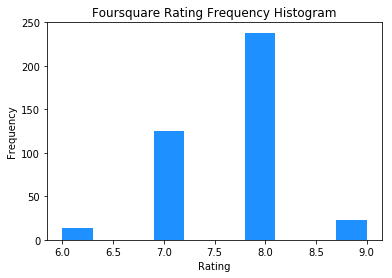

In [50]:
import collections
x = best_restaurants['Foursquare_Rating'].values
#y = collections.Counter(x)

plt.hist(x, bins = 10, color='dodgerblue')
plt.gca().set(title='Foursquare Rating Frequency Histogram', xlabel='Rating', ylabel='Frequency')

plt.show()

#### Recommandation Map

In [51]:
temp_rating = pd.DataFrame({'mean' : best_restaurants.groupby( "Centroid" )["Foursquare_Rating"].mean()}).reset_index()

In [52]:
clusters['Rating'] = clusters['Centroid'].map(temp_rating.set_index('Centroid')['mean'])
clusters.head(20)

,Latitude,Longitude,Centroid,Rating
0,48.863780,2.362518,0,7.878788
1,48.871408,2.340270,1,7.863636
2,48.858312,2.316944,2,7.687500
3,48.880616,2.388727,3,7.307692
4,48.890066,2.342120,4,7.894737
5,48.845188,2.348790,5,7.777778
6,48.864678,2.281594,6,7.695652
7,48.844283,2.389642,7,7.166667
8,48.884176,2.322141,8,7.642857
9,48.841848,2.299391,9,7.294118


In [53]:
p_25 = clusters['Rating'].quantile(0.25)
p_50 = clusters['Rating'].quantile(0.5)
p_75 = clusters['Rating'].quantile(0.75)

rating_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)

# FastMarkerCluster(data=list(zip(df['lat'].values, df['lng'].values))).add_to(map)
# folium.LayerControl().add_to(map)

markers_colors = []
for lat, lon, poi, rat in zip(clusters['Latitude'], clusters['Longitude'], clusters['Centroid'], clusters['Rating']):
    label = folium.Popup(str(poi) + ' Cluster ', parse_html=True)
    if rat < p_25:
        set_opacity = 0.1
    elif rat < p_50:
        set_opacity = 0.3
    elif rat < p_75:
        set_opacity = 0.7
    else:
        set_opacity = 0.9
    folium.CircleMarker(
        [lat, lon],
        radius=50,
        popup=label,
        color='Red',
        fill=True,
        fill_color='Red',
        fill_opacity=set_opacity).add_to(rating_map)
    
rating_map

### Recommandation Map - Foursquare Likes

#### Vizualizing Likes Distribution

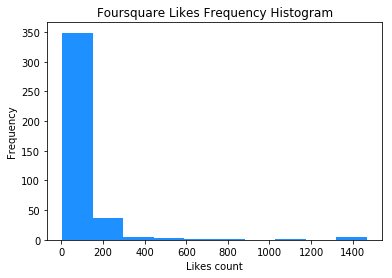

In [54]:
x = best_restaurants['Foursquare_Likes'].values

plt.hist(x, bins=10, color='dodgerblue')
plt.gca().set(title='Foursquare Likes Frequency Histogram', xlabel='Likes count', ylabel='Frequency')

plt.show()

In [55]:
top_foursquare = best_restaurants.sort_values('Foursquare_Likes',ascending=False).head(30)
top_foursquare

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers,Centroid
370,Faubourg-Montmartre,48.871944,2.341604,Hard Rock Cafe,4b1d4f79f964a520980e24e3,0.015811,1468,8,,0.0,1
17,Chaussée-d'Antin,48.871944,2.341604,Hard Rock Cafe,4b1d4f79f964a520980e24e3,0.015811,1468,8,,0.0,1
181,Rochechouart,48.871944,2.341604,Hard Rock Cafe,4b1d4f79f964a520980e24e3,0.015811,1468,8,,0.0,1
314,Saint-Georges,48.871944,2.341604,Hard Rock Cafe,4b1d4f79f964a520980e24e3,0.015811,1468,8,,0.0,1
60,Rochechouart,48.871861,2.342989,Bouillon Chartier,4b335de3f964a520e51825e3,0.015811,1120,8,,0.0,1
364,Saint-Thomas-d'Aquin,48.854678,2.332847,Le Relais de l'Entrecôte,4b3764d6f964a520d94025e3,0.015811,856,8,,0.0,15
203,Sainte-Avoie,48.860613,2.361804,Breizh Café,4b003268f964a520673b22e3,0.015811,641,8,,0.0,0
200,Sainte-Avoie,48.862940,2.362580,Café Charlot,4b026607f964a520894822e3,0.015811,524,8,,0.0,0
322,Arts-et-Métiers,48.864470,2.354178,Le Derrière,4b391111f964a5206c5525e3,0.015811,495,9,,0.0,14
246,Place-Vendôme,48.861740,2.335646,Le Café Marly,4adcda04f964a520503221e3,0.015811,446,8,beaumarly_paris,4525.0,10


In [56]:
locations = top_foursquare[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
paris_lat = 48.8534
paris_lng = 2.3488

likes_rating_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)

markers_colors = []
for lat, lon, poi, rat in zip(clusters['Latitude'], clusters['Longitude'], clusters['Centroid'], clusters['Rating']):
    label = folium.Popup(str(poi) + ' Cluster ', parse_html=True)
    if rat < p_25:
        set_opacity = 0.1
    elif rat < p_50:
        set_opacity = 0.3
    elif rat < p_75:
        set_opacity = 0.7
    else:
        set_opacity = 0.9
    folium.CircleMarker(
        [lat, lon],
        radius=50,
        popup=label,
        color='Red',
        fill=True,
        fill_color='Red',
        fill_opacity=set_opacity).add_to(likes_rating_map)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], icon=folium.Icon(color='pink', icon="foursquare", prefix='fa')).add_to(likes_rating_map)
    
likes_rating_map

### Recommandation Map - Instagram Followers

#### Vizualizing Followers Distribution

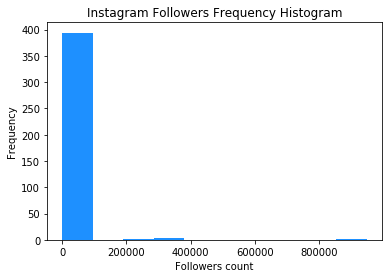

In [57]:
x = best_restaurants['Instagram_Followers'].values

plt.hist(x, bins=10, color='dodgerblue')
plt.gca().set(title='Instagram Followers Frequency Histogram', xlabel='Followers count', ylabel='Frequency')

plt.show()

In [58]:
top_insta = best_restaurants.sort_values('Instagram_Followers',ascending=False).head(30)
top_insta

,Neighborhood,Latitude,Longitude,Venue,Id,Eigenvector Centrality,Foursquare_Likes,Foursquare_Rating,Instagram_Account,Instagram_Followers,Centroid
313,Saint-Georges,48.872090,2.340420,Chipotle Mexican Grill,4eb85eadbe7bfc284b8c1931,0.015811,407,8,chipotle,950114.0,1
214,Palais-Royal,48.862295,2.346522,Champeaux,5708bc2bcd100e461669a3a4,0.015811,64,7,alainducasse,363918.0,14
57,Saint-Germain-l'Auxerrois,48.862295,2.346522,Champeaux,5708bc2bcd100e461669a3a4,0.015811,64,7,alainducasse,363918.0,14
149,Gros-Caillou,48.855712,2.316920,Arpège,4adcda13f964a520af3621e3,0.015811,166,8,alain_passard,356454.0,2
329,Saint-Thomas-d'Aquin,48.855712,2.316920,Arpège,4adcda13f964a520af3621e3,0.015811,166,8,alain_passard,356454.0,2
71,Picpus,48.833206,2.386972,Five Guys,570fa5dbcd10a1d949b374ef,0.015811,98,6,fiveguys,277446.0,7
362,Saint-Thomas-d'Aquin,48.860195,2.309622,David Toutain,52af6d4a498e6d8ddfc6caa4,0.015811,88,9,david_toutain,50985.0,2
393,Arts-et-Métiers,48.863843,2.362661,Paris New York,551ab159498e0f0eb50a5a1f,0.015811,265,9,pnyburger,29724.0,0
293,Plaine de Monceaux,48.887718,2.320194,Melt,5a60de91ee628b4830a34175,0.015811,26,8,melt.paris,27706.0,8
171,Sainte-Avoie,48.863614,2.355505,Love Juice Bar,58946a922a198259b0ea45a0,0.015811,20,8,lovejuicebarparis,12110.0,0


In [59]:
locations = top_insta[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()
paris_lat = 48.8534
paris_lng = 2.3488

insta_rating_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)

markers_colors = []
for lat, lon, poi, rat in zip(clusters['Latitude'], clusters['Longitude'], clusters['Centroid'], clusters['Rating']):
    label = folium.Popup(str(poi) + ' Cluster ', parse_html=True)
    if rat < p_25:
        set_opacity = 0.1
    elif rat < p_50:
        set_opacity = 0.3
    elif rat < p_75:
        set_opacity = 0.7
    else:
        set_opacity = 0.9
    folium.CircleMarker(
        [lat, lon],
        radius=50,
        popup=label,
        color='Red',
        fill=True,
        fill_color='Red',
        fill_opacity=set_opacity).add_to(insta_rating_map)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], icon=folium.Icon(color='purple', icon="instagram", prefix='fa')).add_to(insta_rating_map)
    
insta_rating_map

In [99]:
### Final Recommandation Map

In [63]:
foursquare_locations = top_foursquare[['Latitude', 'Longitude']]
foursquare_locationlist = foursquare_locations.values.tolist()
foursquare_rest = top_foursquare['Venue'].reset_index()
insta_locations = top_insta[['Latitude', 'Longitude']]
insta_locationlist = insta_locations.values.tolist()
insta_rest = top_insta['Venue'].reset_index()
paris_lat = 48.8534
paris_lng = 2.3488

final_rating_map = folium.Map(location=[paris_lat, paris_lng], zoom_start=13)

markers_colors = []
for lat, lon, poi, rat in zip(clusters['Latitude'], clusters['Longitude'], clusters['Centroid'], clusters['Rating']):
    if poi == 0:
        neigh = 'Marais'
    elif poi ==1:
        neigh = 'Grands Boulevards'
    elif poi == 2:
        neigh = 'Solférino'
    elif poi == 3:
        neigh = 'Ourcq'
    elif poi == 4:
        neigh = 'Pigalle - Montmartre'
    elif poi == 5:
        neigh = 'Mouffetard'
    elif poi == 6:
        neigh = 'La Muette'
    elif poi == 7:
        neigh = 'Reuilly-Diderot'
    elif poi == 8:
        neigh = 'Batignolles'
    elif poi == 9:
        neigh = 'Pasteur-Convention'
    elif poi == 10:
        neigh = 'Louvres-Rivoli'
    elif poi == 11:
        neigh = 'Ménilmontant'
    elif poi == 12:
        neigh = 'Gaîté - Alésia'
    elif poi == 13:
        neigh = 'Voltaire'
    elif poi == 14:
        neigh = 'Sentier - Montorgueil - Les Halles'
    elif poi == 15:
        neigh = 'Saint Germain des Prés'
    elif poi == 16:
        neigh = 'Canal Saint Martin - Jaurès'
    
    label = folium.Popup(str(neigh)+' '+str(round(rat,1)), parse_html=True)
    if rat < p_25:
        set_radius = 20
    elif rat < p_50:
        set_radius = 30
    elif rat < p_75:
        set_radius = 45
    else:
        set_radius = 60
    folium.CircleMarker(
        [lat, lon],
        radius=set_radius,
        popup=label,
        color='transparent',
        fill=True,
        fill_color='Blue',
        fill_opacity=0.7).add_to(final_rating_map)

i = 0
for point in range(0, len(foursquare_locationlist)):
    label = folium.Popup(foursquare_rest.iloc[i]['Venue'], parse_html=True)
    i += 1
    folium.Marker(foursquare_locationlist[point], popup=label, icon=folium.Icon(color='pink', icon="foursquare", prefix='fa')).add_to(final_rating_map)

i = 0
for point in range(0, len(insta_locationlist)):
    label = folium.Popup(insta_rest.iloc[i]['Venue'], parse_html=True)
    i += 1
    folium.Marker(insta_locationlist[point], popup=label, icon=folium.Icon(color='purple', icon="instagram", prefix='fa')).add_to(final_rating_map)

title_lat = 48.91
title_lng = 2.28
title_text = "Recommended Restaurant Areas in Paris If You are a Millennial"

folium.Marker(
        [title_lat, title_lng],
            icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="width:580pt;color:black;background-color:white;opacity:0.7;font-size:20pt;text-align:center;">%s</div>' % title_text)).add_to(final_rating_map)

legend_lat = 48.87
legend_lng = 2.42
legend_text = "A wide circle indicates that restaurants of the area have a high rating on Foursquare.<br/><br/>" \
    + "Foursquare and Instragram markers enable you to quickly locate most followed venues on each respective social network."

folium.Marker(
        [legend_lat, legend_lng],
            icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="width:180pt;color:black;background-color:white;opacity:0.7;font-size:10pt;text-align:justify;">%s</div>' % legend_text)).add_to(final_rating_map)

final_rating_map